## Designing an observer for LTI system
Reference:  
[1] http://y373.sakura.ne.jp/minami/pyctrl  
[2] "Pythonによる制御工学入門(第1版)", 南裕樹, オーム社  
[3] "Control Engineering: MATLAB Exercies", Laszlo.K et al, Springer

In the previous section, we have discussed the state feedback for LTI system. State feedback uses the "states" of the system, which means the displacement, velocity, angle, or angular velocity are assumed to be measureable. But what if one or some of those values are inmeasureable?
Observer provides us to estimate the states.

### full-order observer
Let us assume the sytem s.t. it estimates the all of the states by:
$$
\dot{\hat{\boldsymbol{x}}}(t) = \boldsymbol{A}\hat{\boldsymbol{x}}(t) + \boldsymbol{B}u(t) - \boldsymbol{L}(y(t) - \boldsymbol{C}\hat{\boldsymbol{x}}(t))
$$

This makes sense because the first and second terms of the right wing derives from the model itself. The third term multiplies gain $\boldsymbol{L}$ to the error between the output $y(t)$ and the estimated output $C\hat{\boldsymbol{x}}(t)$

Now, let us define the error between the true state and estimated state as:
$$
\boldsymbol{e}(t) = \boldsymbol{x}(t) - \boldsymbol{\hat{x}}(t)
$$
Then this yields:
$$
\boldsymbol{\dot{e}}(t) = \boldsymbol{\dot{x}}(t) - \boldsymbol{\dot{\hat{x}}}(t) = (\boldsymbol{A} + \boldsymbol{LC})\boldsymbol{e}(t)
$$

This means that the error converges to zero ($\boldsymbol{e}(t) \to 0$) if we properly design the obsever gain $\boldsymbol{L}$. When the error is negated, $\boldsymbol{\hat{x}}(t)$ must be good estimation of $\boldsymbol{x}(t)$.

Here we see the analogy with the pole-placement method of LTI feedback system. ($\dot{x} = (A+BK)x$) By transposing $(A+LC)^T = A^T + C^TL^T$, ackerman's pole placement method becomes applicable to the observer gain.

Let us see how observer works in the python code below.

Now we can see that observer is also one type of sytems since it can be represented as:
$$
\boldsymbol{\dot{\hat{x}}}(t) = (\boldsymbol{A}+\boldsymbol{LC})\boldsymbol{\hat{x}}(t) +
[\begin{matrix} \boldsymbol{B} & -\boldsymbol{L} \end{matrix}]\left[\begin{matrix} u(t) \\ y(t) \end{matrix}\right]
$$

Thereby lsim/ss function of python-control visualizes the behavior of the observer.

In [1]:
import control.matlab as ctrl
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

observer poles:  [-15.+5.j -15.-5.j]
regulator poles:  [-5.+5.j -5.-5.j]


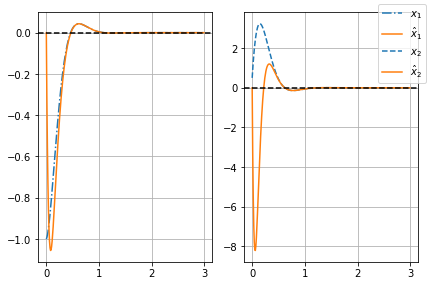

In [5]:
A = '0 1; -4 5'
B = '0; 1'
C = '1 0'
D = '0'

P = ctrl.ss(A, B, C, D)

#observer's pole
obs_pole = [-15+5j, -15-5j]

#observer's gain
L = -ctrl.acker(P.A.T, P.C.T, obs_pole).T
print("observer poles: ", np.linalg.eigvals(P.A+L*P.C))

Td = np.arange(0, 3, 0.01)  # time range 
X0 = [-1, 0.5]  # the initial state

regulator_poles = [-5+5j, -5-5j]
F = -ctrl.acker(P.A, P.B, regulator_poles)
print("regulator poles: ", np.linalg.eigvals(P.A+P.B*F))

# true behavior of the state
G_statefb = ctrl.ss(P.A + P.B*F, P.B, np.eye(2), [[0], [0]])
#i.e.) outputting two states without external disturbance
x, t = ctrl.initial(G_statefb, Td, X0)

fig, ax = plt.subplots(1, 2)
ax[0].plot(t, x[:, 0], ls="-.", label="$x_1$")
ax[1].plot(t, x[:, 1], ls="--", label="$x_2$")

# estimated behavior of the state

# u = Fx -> u = f1*x1 + f2*x2
u = [] # input u = Fx
for i in range(len(x)):
    f1 = F[0, 0]
    f2 = F[0, 1]
    x1 = x[i, 0]
    x2 = x[i, 1]
    u.append([f1*x1 + f2*x2])
    
# output y = Cx
y = x[:, 0]

# state estimation by observer
Obs = ctrl.ss(P.A + L*P.C, np.c_[P.B, -L], np.eye(2), [[0, 0], [0, 0]])
xhat, t, x0 = ctrl.lsim(Obs, np.c_[u, y], Td, [0, 0])

ax[0].plot(t, xhat[:, 0], label="$\hat{x}_1$")
ax[1].plot(t, xhat[:, 1], label="$\hat{x}_2$")

ax[0].axhline(0, ls="--", color="k")
ax[0].grid()

ax[1].axhline(0, ls="--", color="k")
ax[1].grid()

fig.legend()
fig.tight_layout()

Let us use the estimated state $\hat{x}$ to establish the state feedback $u = \boldsymbol{F\hat{x}}$.
The equation of the observer is:

$$
\boldsymbol{\dot{\hat{x}}} = (\boldsymbol{A} + \boldsymbol{LC})\boldsymbol{\hat{x}}(t) + \boldsymbol{B}u(t) + \boldsymbol{-L}y(t) 
$$

Having $u(t) = \boldsymbol{F\hat{x}}(t)$, this yields:
$$
\boldsymbol{\dot{\hat{x}}} = (\boldsymbol{A+BF+LC})\boldsymbol{\hat{x}}(t) - \boldsymbol{L}y(t) \\
\boldsymbol{\hat{X}}(s) = (\boldsymbol{A+BF+LC}-s\boldsymbol{I})^{-1}\boldsymbol{L}Y(s) \\
U(s) = \boldsymbol{F}(\boldsymbol{A+BF+LC}-s\boldsymbol{I})^{-1}\boldsymbol{L}Y(s)
$$

Let us see the behavior of the state feedback with full-order observer below. 

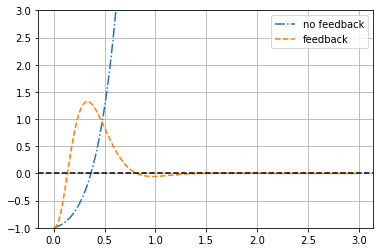

In [12]:
# state feedback
regulator_poles = [-5+5j, -5-5j]
F = -ctrl.acker(P.A, P.B, regulator_poles)

# observer gain
observer_poles = [-15+5j, -15-5j]
L = -ctrl.acker(P.A.T, P.C.T, observer_poles).T

# controller (observer + state feedback)
K = ctrl.ss(P.A + P.B*F + L*P.C, -L, F, 0)
# feedback system
Gfb = ctrl.feedback(P, K, sign=1)

Y0 = [-1, 0.5]
Td = np.arange(0, 3, 0.01)
y, t = ctrl.initial(P, Td, Y0)
plt.plot(t, y, ls="-.", label="no feedback")

Y0 = [-1, 0.5, 0, 0]
y, t = ctrl.initial(Gfb, Td, Y0)
plt.plot(t, y, ls="--", label="feedback")

plt.ylim(-1, 3)
plt.grid()
plt.legend()
plt.axhline(0, ls="--", color="k")
plt.show()